#  Анализ поведелние пользователей приложения "Ненужные вещи"

## Задача:

Выделить группы пользователей, различающихся по следующим метрикам:

- Количество сессий;

- Время, проведенное в приложении;

- Частота действий;

- Конверсия в целевое действие - просмотр контактов.

Сегментировать пользователей на основе действий

Проверить статистические гипотезы:

- Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверить гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов;

- Выдвинуть гипотезу после проведения исследовательского анализа данных.

## Загрузка и знакомство с данными

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 90em; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим датасеты
events_data = pd.read_csv(r"D:\!!! Учеба !!!\Аналитика\Проекты\Выпускной проект\Основной проект\mobile_dataset.csv")
source_data = pd.read_csv(r"D:\!!! Учеба !!!\Аналитика\Проекты\Выпускной проект\Основной проект\mobile_soures.csv")

In [3]:
events_data.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


- _event.time_ — время совершения 

- _event.name_ — название события 

- _user.id_ — идентификатор пользователя 

In [4]:
# посмотрим на события
events_data['event.name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event.name, dtype: int64

<div class="alert alert-block alert-info">
    
- _advert_open_ — открытие карточки объявления
- _photos_show_ — просмотр фотографий в объявлении
- _tips_show_ — пользователь увидел рекомендованные объявления
- _tips_click_ — пользователь кликнул по рекомендованному объявлению
- _contacts_show и show_contacts_ — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- _contacts_call_ — пользователь позвонил по номеру телефона на карточке объявления
- _map_ — пользователь открыл карту размещенных объявлений
- _search_1 — search_7_ — разные события, связанные с поиском по сайту
- _favorites_add_ — добавление объявления в избранное
</div>

In [5]:
source_data.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


<div class="alert alert-block alert-info">
    
- _userId_ — идентификатор пользователя
- _source_ — источник, с которого пользователь установил приложение
</div>

## Предобработка данных

1. Проверка на пропуска;
2. Проверка на типы данных;
3. Проверка имен столбцов;
4. Проверка на дубликаты; 
5. У нас есть одно событие "посмотреть номер телефона" записанное в таблице двумя разными способами, исправить;

In [6]:
events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [7]:
source_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [8]:
print('Дубликатов в таблице с событиями:',events_data.duplicated().sum())
print('Дубликатов в таблице с источниками:',events_data.duplicated().sum())

Дубликатов в таблице с событиями: 0
Дубликатов в таблице с источниками: 0


<div class="alert alert-block alert-info">
Пропусков и дубликатов в таблицы нет, нужно привести дату к нужному типу, переименовать столбец "userId" в таблице с источниками и заменить значения contacts_show на show_contacts.
</div>

In [9]:
events_data['event.time'] = pd.to_datetime(events_data['event.time'])
source_data = source_data.rename(columns = {'userId':'user.id'})
events_data['event.name'] = events_data['event.name'].replace({'contacts_show':'show_contacts'})

### Итоги предобработки данных

Данные проверены на пропуски и дубликаты, даты приведены к нужному типу данных, переименован столбец в таблице с источниками и событие "просмотр контакта" записано в таблице уникальным обозначением - "show_contacts".

Можно приступать к исследовательскому анализу

## 3) Исследовательский анализ данных

1. Посмотреть на количество пользователей;
2. Посмотреть данными за какой временной промежуток мы располагаем;
3. Построить гистограмму по дате и времени, определить за весь промежуток времени мы располагаем полными данными или нет;
4. Разбить лог на сессии
5. Посчитать как часто пользователи возвращаются в приложение - количество сессий. Выделить группы пользователей, различающихся по данной метрики
5. Посчитать сколько времени пользователи проводили в приложении. Выделить группы пользователей, различающихся по времени, проведенному в приложении;
6. Посмотреть сколько раз совершалось каждое из событий, построить диаграмму;
7. Посчитать сколько событий совершил каждый из пользователей. Выделить группы пользователей, различающихся по активности в приложении;
8. Посчитать сколько раз каждый из пользователей совершал целевое действие - просмотр контакта. Выделить группы пользователей, различающихся по количеству просмотров контактов;
9. Выдвинуть гипотезы для статистической проверки;

<div class="alert alert-block alert-info">
Найдем количество пользователей
</div>

In [10]:
print('Количество пользователей:', len(events_data['user.id'].unique()))

Количество пользователей: 4293


<div class="alert alert-block alert-info">
Определим временной промежуток
</div>

In [11]:
print('Начало:', events_data['event.time'].min())
print('Конец:', events_data['event.time'].max())

Начало: 2019-10-07 00:00:00.431357
Конец: 2019-11-03 23:58:12.532487


<div class="alert alert-block alert-info">
У нас есть данные за 28 дней, с 7-го октября по 3-е ноября. Посмотрим, как распределены события на данном временном отрезке.
</div>

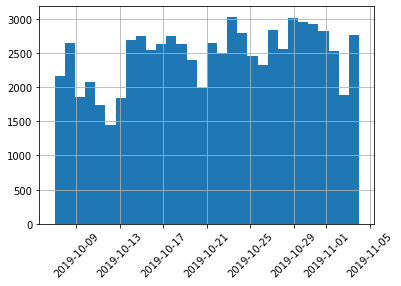

In [12]:
events_data['event.time'].hist(bins = 30)
plt.xticks(rotation=45)
plt.show()

<div class="alert alert-block alert-info">
Отлично, у нас есть данные о событиях за весь временной промежуток.
    
Перейдем к разделению лога на сессии. Посчитаем разницу между совршенными событиями для каждого пользователя, посмотрим на распреление этой разницы и определим то время, которое можно будет считать уже началом новой сессии, а не продолжением предыдущей
</div>

In [13]:
# Присвоим каждому событию уникальный id
events_data = events_data.reset_index().rename(columns={'index':'id'})

In [14]:
# Для каждого события пользователя посчитаем разницу с предыдущим событием
events_data['diff'] = events_data.groupby('user.id')['event.time'].diff(1)

# Посмотрим на датасет
events_data.head()

,id,event.time,event.name,user.id,diff
0,0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,NaT
1,1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,00:00:00.804963
2,2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,NaT
3,3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,00:00:05.803014
4,4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,00:00:54.074472


In [15]:
# посчитаем разницу
events_data['diff_check'] = (events_data['diff'].dt.seconds)

<div class="alert alert-block alert-info">
Для проверки ограничим визуализацию до получаса - 1800 секунд
</div>


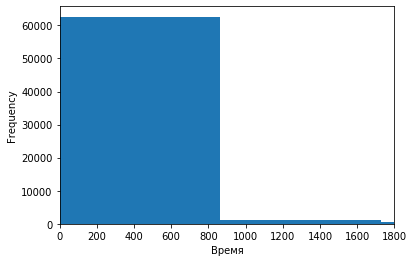

In [16]:
events_data['diff_check'].plot(kind = 'hist', bins = 100)
plt.xlabel('Время')
plt.xlim(0, 1800)
plt.show()

<div class="alert alert-block alert-info">
Мы видим, что на отметке в 850 секунд число совершаемых событий резко падает. Будем считать эту разницу между временем совершаемых действий за начало новой сессии. Сделаем таблицу с первыми сессиями.
</div>

In [17]:
start_session = events_data[(events_data['diff'].isnull()) | (events_data['diff'] > '850 seconds')]
start_session['session_id'] = start_session['id']
start_session.head()

,id,event.time,event.name,user.id,diff,diff_check,session_id
0,0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,NaT,NaN,0
2,2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,NaT,NaN,2
12,12,2019-10-07 00:02:07.374346,tips_show,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,NaT,NaN,12
25,25,2019-10-07 00:05:20.190956,search_4,d9b06b47-0f36-419b-bbb0-3533e582a6cb,NaT,NaN,25
37,37,2019-10-07 00:09:33.715659,tips_show,f32e1e2a-3027-4693-b793-b7b3ff274439,NaT,NaN,37


In [18]:
# Соединим таблицы с помощью функции merge_asof
event_sessions = pd.merge_asof(events_data,start_session[['id','user.id','session_id']],on='id',by='user.id')
event_sessions.head()

,id,event.time,event.name,user.id,diff,diff_check,session_id
0,0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,NaT,NaN,0
1,1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,00:00:00.804963,0.0,0
2,2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,NaT,NaN,2
3,3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,00:00:05.803014,5.0,0
4,4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,00:00:54.074472,54.0,2


In [19]:
# Сгруппируем по пользователю и сессии
sessions_table = event_sessions.groupby(['user.id', 'session_id']).agg(session_start = ('event.time', 'min'),
                                                   session_end = ('event.time', 'max')).reset_index()

# Найдем время сессии в минутах
sessions_table['session_time'] = ((sessions_table['session_end'] - sessions_table['session_start']).dt.seconds)/60

sessions_table.head(5)

,user.id,session_id,session_start,session_end,session_time
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,805,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,9.916667
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,6541,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,8.450000
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,36412,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,14.983333
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,37556,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,12.633333
4,00157779-810c-4498-9e05-a1e9e3cedf93,31632,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,25.333333


In [20]:
# Посчитаем  количество сессий и среднее время сессии каждого пользователя
mean_session = sessions_table.groupby('user.id').agg(mean_session = ('session_time', 'mean'),
                                                    count_session = ('session_time', 'count')).reset_index()

# Округлим значения вверх
mean_session['mean_session'] = mean_session['mean_session'].apply(np.ceil).astype(int)
mean_session.head()

,user.id,mean_session,count_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,12,4
1,00157779-810c-4498-9e05-a1e9e3cedf93,15,9
2,00463033-5717-4bf1-91b4-09183923b9df,25,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,4,10
4,00551e79-152e-4441-9cf7-565d7eb04090,4,3


<div class="alert alert-block alert-info">
У нас есть среднее время сессии и количество сессий для каждого пользователя. Посмотрим на распределение данных.
</div>

In [21]:
mean_session.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_session,4293.0,11.212905,11.477169,0.0,4.0,8.0,15.0,125.0
count_session,4293.0,2.721174,4.261360,1.0,1.0,2.0,3.0,118.0


<div class="alert alert-block alert-info">
В данных большой разброс, посмотрим на распределение на гистограмме. Начнем с количества сессий.
</div>


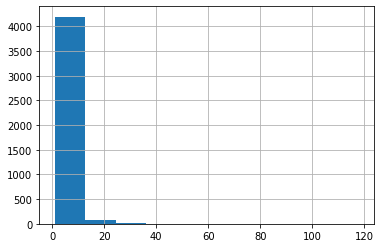

In [22]:
mean_session['count_session'].hist()

<div class="alert alert-block alert-info">
Уменьшим масштаб
</div>

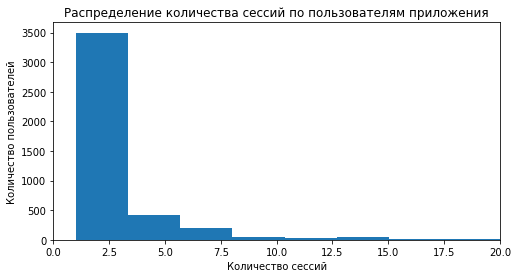

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))

mean_session['count_session'].plot(kind = 'hist', bins = 50)
plt.title('Распределение количества сессий по пользователям приложения')
plt.xlabel('Количество сессий')
plt.ylabel('Количество пользователей')
plt.xlim(0, 20)
plt.show()

<div class="alert alert-block alert-info">
Поделим пользователей на следующие группы:

- 1 сессия - не возвращался в приложение
- 2-5 сессий - не часто пользовался приложением
- 6-10 сессий - часто заходит в приложение
- 11-20 сессий - пользуется приложением регулярно
- более 20 сессий - не может без ненужных вещей
</div>


In [61]:
# категоризируем пользователей
def group_count(row):
        if row <= 1:
            return '1 сессия'
        if row <= 5:
            return '2-5 сессий'
        if row <= 10:
            return '6-10 сессий'
        if row <= 20:
            return '11-20 сессий'
        if row > 20:
            return 'более 20 сессий'
mean_session['group_count'] = mean_session['count_session'].apply(group_count)
mean_session.head()

,user.id,mean_session,count_session,group_count,group_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,12,4,2-5 сессий,6-20 минут
1,00157779-810c-4498-9e05-a1e9e3cedf93,15,9,6-10 сессий,6-20 минут
2,00463033-5717-4bf1-91b4-09183923b9df,25,1,1 сессия,21-40 минут
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,4,10,6-10 сессий,1-5 минут
4,00551e79-152e-4441-9cf7-565d7eb04090,4,3,2-5 сессий,1-5 минут


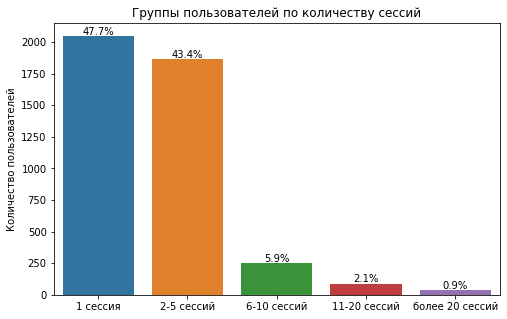

In [62]:
# Построим распределение

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x='group_count', data = mean_session, order = mean_session['group_count'].value_counts().index)
plt.title('Группы пользователей по количеству сессий')
plt.xlabel('')
plt.ylabel('Количество пользователей')

total = len(mean_session)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
    height + 10,
    '{:.1%}'.format(height/total),
    ha="center")
plt.show()

<div class="alert alert-block alert-info">
52.8 % пользователей хотя бы один раз возвращались в приложение, это неплохой показатель. Но активных пользователей, у которых более 10 сессий очень мало.
    
Перейдем к времении сессии.
</div>

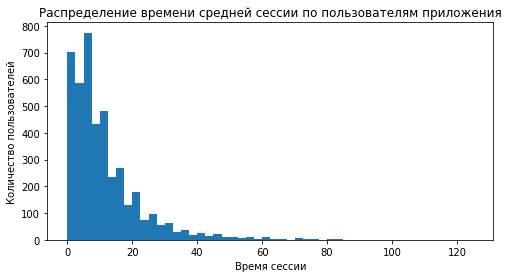

In [26]:
# Построим распределение
fig, ax = plt.subplots(figsize=(8, 4))
ax = mean_session['mean_session'].plot(kind = 'hist', bins = 50)
plt.title('Распределение времени средней сессии по пользователям приложения')
plt.xlabel('Время сессии')
plt.ylabel('Количество пользователей')
plt.show()

<div class="alert alert-block alert-info">
Все достаточно ожидаемо, для того, чтобы найти нужную себе "ненужную вещь" большинству пользователей не требуется больше 20-ти минут, а половине пользователей больше 10-ти.
    
Выделим следующие группы пользователей:
- 0 минут, сессии по сути вообще не было, скорее всего это был простой переход по ссылке из поисковика
- 1 - 5 минут, короткая сессия, быстро посмотрели что нужно
- 6 - 20 минут, средняя продолжительность сессии
- 21 - 40 минут, большая сессия пользователь долго искал нужную себе "ненужную вещь"
- более 40 минут, пользователь залип в приложении
</div>

In [27]:
# Категоризируем пользователей
def group_session(row):
        if row <= 0:
            return 'Нулевая сессия'
        if row <= 5:
            return '1-5 минут'
        if row <= 20:
            return '6-20 минут'
        if row <= 40:
            return '21-40 минут'
        if row > 40:
            return 'более 40 минут'
mean_session['group_session'] = mean_session['mean_session'].apply(group_session)
mean_session.head()

,user.id,mean_session,count_session,group_count,group_session
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,12,4,2-5 сессий,6-20 минут
1,00157779-810c-4498-9e05-a1e9e3cedf93,15,9,6-10 сессий,6-20 минут
2,00463033-5717-4bf1-91b4-09183923b9df,25,1,1 сессия,21-40 минут
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,4,10,6-10 сессий,1-5 минут
4,00551e79-152e-4441-9cf7-565d7eb04090,4,3,2-5 сессий,1-5 минут


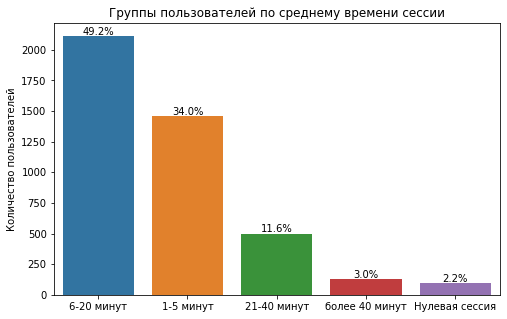

In [28]:
# Построим распределение

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x='group_session', data = mean_session, order = mean_session['group_session'].value_counts().index)
plt.title('Группы пользователей по среднему времени сессии')
plt.xlabel('')
plt.ylabel('Количество пользователей')


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
    height + 10,
    '{:.1%}'.format(height/total),
    ha="center")
plt.show()

<div class="alert alert-block alert-info">
Посмотрим сколько раз совершалось каждое из событий в логе.
</div>

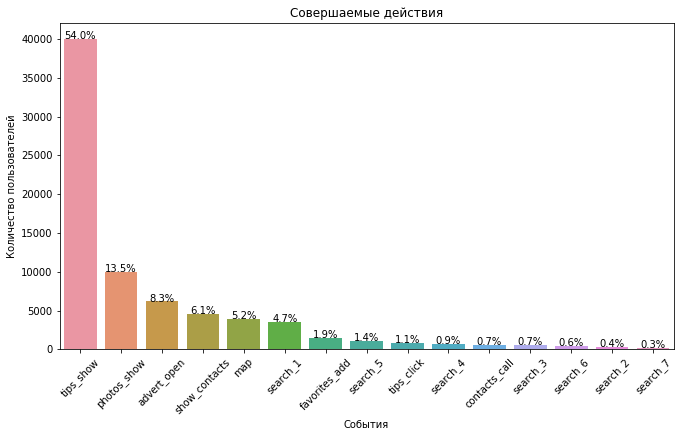

In [29]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.countplot(x='event.name', data = events_data, order = events_data['event.name'].value_counts().index)
plt.title('Совершаемые действия')
plt.xlabel('События')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)

total_1 = len(events_data)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
    height + 3,
    '{:.1%}'.format(height/total_1),
    ha="center")
plt.show()

<div class="alert alert-block alert-info">

Посмотрим сколько событий совершил каждый из пользователей    
</div>

In [30]:
user_events = events_data.groupby('user.id').agg(count_event = ('event.name', 'count')).reset_index()
user_events.head()

,user.id,count_event
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8


In [31]:
user_events.describe().T

,count,mean,std,min,25%,50%,75%,max
count_event,4293.0,17.283252,29.130677,1.0,5.0,9.0,17.0,478.0


<div class="alert alert-block alert-info">
Наблюдается очень большой разрос данных, среднее значение в два раза выше медианного и почти вдвое меньше стандартного отклонения. Для деления пользователей на группы посмотрим на гистограмму, ограничив количество соверщаемых событий до 100.
</div>

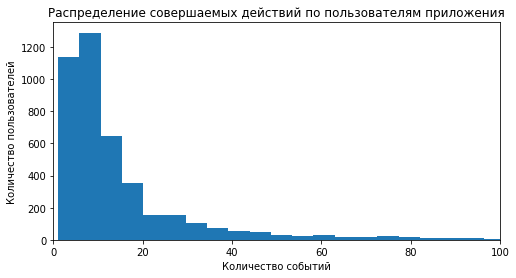

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = user_events['count_event'].plot(kind = 'hist', bins = 100)
plt.title('Распределение совершаемых действий по пользователям приложения')
plt.xlabel('Количество событий')
plt.xlim(0, 100)
plt.ylabel('Количество пользователей')
plt.show()

<div class="alert alert-block alert-info">
    
Выделим следующие группы пользователей:
- совершивших одно действие
- от 2 до 10 действий - малоактивные пользователи
- от 11 до 30 действий - пользователи со средней активностью
- от 31 до 60 действий - активные пользователи
- более 60 действий - пользователям очень нравится наше приложение
</div>

In [33]:
# Категоризируем пользователей
def group_events(row):
        if row <= 1:
            return '1 действие'
        if row <= 10:
            return '2-10 действий'
        if row <= 30:
            return '11-30 действий'
        if row <= 60:
            return '31-60 действий'
        if row > 60:
            return 'более 60 действий'
user_events['group_events'] = user_events['count_event'].apply(group_events)
user_events.head()

,user.id,count_event,group_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35,31-60 действий
1,00157779-810c-4498-9e05-a1e9e3cedf93,71,более 60 действий
2,00463033-5717-4bf1-91b4-09183923b9df,10,2-10 действий
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32,31-60 действий
4,00551e79-152e-4441-9cf7-565d7eb04090,8,2-10 действий


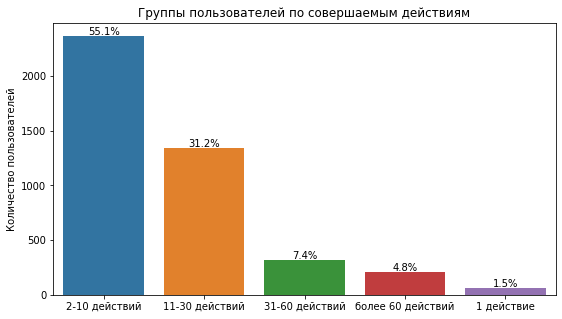

In [34]:
# Построим распределение

fig, ax = plt.subplots(figsize=(9, 5))
ax = sns.countplot(x='group_events', data = user_events, order = user_events['group_events'].value_counts().index)
plt.title('Группы пользователей по совершаемым действиям')
plt.xlabel('')
plt.ylabel('Количество пользователей')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
    height + 10,
    '{:.1%}'.format(height/total),
    ha="center")
plt.show()

<div class="alert alert-block alert-info">
Посчитаем сколько раз каждый из пользователей совершал целевое действие - просмотр контакта
</div>

In [35]:
user_events.head()

,user.id,count_event,group_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35,31-60 действий
1,00157779-810c-4498-9e05-a1e9e3cedf93,71,более 60 действий
2,00463033-5717-4bf1-91b4-09183923b9df,10,2-10 действий
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32,31-60 действий
4,00551e79-152e-4441-9cf7-565d7eb04090,8,2-10 действий


In [36]:
events_data.head()

,id,event.time,event.name,user.id,diff,diff_check
0,0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,NaT,NaN
1,1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,00:00:00.804963,0.0
2,2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,NaT,NaN
3,3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,00:00:05.803014,5.0
4,4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,00:00:54.074472,54.0


In [37]:
show_contacts = events_data.pivot_table(index = 'user.id', columns = 'event.name', values = 'diff', aggfunc = 'count')\
.reset_index()

show_contacts = show_contacts[['user.id', 'show_contacts']].fillna(0)

In [38]:
show_contacts.describe().T

,count,mean,std,min,25%,50%,75%,max
event.name,,,,,,,,
show_contacts,4293.0,1.013277,4.957514,0.0,0.0,0.0,0.0,137.0


<div class="alert alert-block alert-info">
Распределение данных очень неравномерно, стандартное отклонение почти в пять раз выше среднего, также видим, что большинство пользователей не доходило до просмотра контактов, наряду с тем, что есть пользователи с очень большим числом просмотров контактных телефонов, что может наталкивать нас на мысль о мошенничестве.
    
Для данной метрики можно выделить три группы пользователей:
- не доходили до просмотра контактов
- просматривали контакты
- подозрительная активность, просмотр более 25 контактов.
    </div>

In [39]:
# Категоризируем пользователей
def group_contacts(row):
        if row <= 0:
            return 'нет просмотров'
        if row <= 25:
            return 'есть просмотры'
        if row > 25:
            return 'подозрительная активность'

show_contacts['contacts_group'] = show_contacts['show_contacts'].apply(group_contacts)
show_contacts.head()

event.name,user.id,show_contacts,contacts_group
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,нет просмотров
1,00157779-810c-4498-9e05-a1e9e3cedf93,11.0,есть просмотры
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,нет просмотров
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,0.0,нет просмотров
4,00551e79-152e-4441-9cf7-565d7eb04090,2.0,есть просмотры


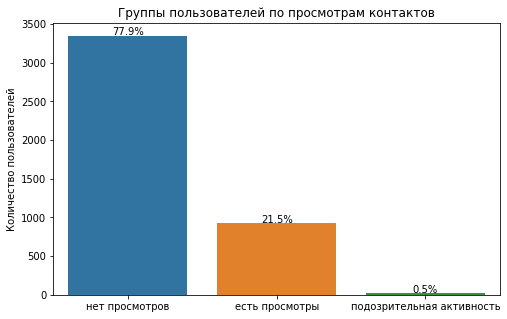

In [40]:
# Построим распределение

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x='contacts_group', data = show_contacts, order = show_contacts['contacts_group'].value_counts().index)
plt.title('Группы пользователей по просмотрам контактов')
plt.xlabel('')
plt.ylabel('Количество пользователей')


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
    height + 10,
    '{:.1%}'.format(height/total),
    ha="center")
plt.show()

<div class="alert alert-block alert-info">
Почти 23% пользователей доходили до целевого действия - просмотра контактов, но 0.5% делали это подозрительно часто
    
Построим итоговую таблицу по результатам исследовательского анализа.
</div>

In [41]:
eda_groups = mean_session.merge(user_events, on='user.id')
eda_groups.head()

,user.id,mean_session,count_session,group_count,group_session,count_event,group_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,12,4,2-5 сессий,6-20 минут,35,31-60 действий
1,00157779-810c-4498-9e05-a1e9e3cedf93,15,9,6-10 сессий,6-20 минут,71,более 60 действий
2,00463033-5717-4bf1-91b4-09183923b9df,25,1,1 сессия,21-40 минут,10,2-10 действий
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,4,10,6-10 сессий,1-5 минут,32,31-60 действий
4,00551e79-152e-4441-9cf7-565d7eb04090,4,3,2-5 сессий,1-5 минут,8,2-10 действий


<div class="alert alert-block alert-info">
Выдвинем гипотезу, что пользователи, которые пользовались картой размещенных объявлений демонстрируют большую конверсию в просмотры контактов, чем пользователи, которые не пользовались картой, но при этом открывали карточки с объявлениями.
</div>

## Итоги исследовательского анализа

1. Количество пользователей в логе - 4293
2. Мы располашаем данными за 28 дней, с 7-го октября по 3 ноября 2019 года
3. Данные о событиях полные за весь рассматриваемый промежуток времени
4. Лог разбит на сессии
5. Выделены группы пользователей в зависимости от количества сессий:
    - 1 сессия - 47.7%
    - 2-5 сессий - 43.4%
    - 6-10 сессий - 8%
    - 11-20 сессий - 0.7%
    - более 20 сессий - 0.1%
6. Выделены группы пользователей в зависимости от среднего времени сессий:
    - 0 минут - 2%
    - 1 - 5 минут - 28%
    - 6 - 20 минут - 46.4%
    - 21 - 40 минут - 17%
    - более 40 минут - 6.5%
7. Выделены группы пользователей в зависимости от количества совершаемых действий:
    - одно действие - 1.5 %
    - от 2 до 10 действий - 55.1%
    - от 11 до 30 действий - 31.2%
    - от 31 до 60 действий - 7.4%
    - более 60 действий - 4.8%
8. Выделены группы пользователей на основе выполнения целевого действия - просмотра контакта:
    - не доходили до просмотра контактов - 77.1%
    - просматривали контакты - 22.3%
    - подозрительная активность, просмотр более 25 контактов 0.5%
9. Построена общая таблица с группами пользователей.
10. Выдвинута гипотеза, что пользователи, которые пользовались картой размещенных объявлений демонстрируют большую конверсию в просмотры контактов, чем пользователи, которые не пользовались картой, но при этом открывали карточки с объявлениями.



## 4) Кластеризация пользователей на основе действий

1. Составить сводную таблицу для кластеризации;
2. Убрать из таблицы столбцы search1 - search7, они не нужны нам для кластеризации;
3. Добавить в таблицу метрики, полученные в результаты EDA: ретеншен, время сессии и количество действий;
3. Стандартизировать данные;
4. Построить дендрограмму, определить оптимальное число кластеров;
5. Кластеризировать пользователей на основании алгоритма K-means;
6. Построить и изучить распределение признаков по кластерам;
7. Посмотреть, как распределились ретеншен, время сессии и количество действий по полученным группам.

<div class="alert alert-block alert-info">
События search1 - search7 не несут за собой никакой информации, мы не знаем какие именно действия за ними скрываются и никак не можем их интерпретировать. В следствие чего в своей работе я бы не учитывал их при кластеризации.
</div>


<div class="alert alert-block alert-info">
Найдем сколько раз пользователи совершали каждое их действий, построив сводную таблицу
</div>

In [42]:
# Построим сводную таблицу
cluster_table = events_data.pivot_table(index = 'user.id', columns = 'event.name', values = 'diff', aggfunc = 'count')\
.reset_index().fillna(0)

# Оставим только нужные нам столбцы
cluster_table = cluster_table[['user.id', 'advert_open', 'contacts_call', 'favorites_add', 'map', 'photos_show',\
                              'show_contacts', 'tips_click', 'tips_show']]

In [43]:
# Добавим ретеншен, время сессии и количество действий
cluster_table = cluster_table.merge(eda_groups[['user.id', 'mean_session', 'count_session', 'count_event']], on='user.id')

In [44]:
cluster_table.head()

,user.id,advert_open,contacts_call,favorites_add,map,photos_show,show_contacts,tips_click,tips_show,mean_session,count_session,count_event
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.0,6.0,0.0,0.0,0.0,28.0,12,4,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,2.0,5.0,2.0,0.0,33.0,11.0,0.0,0.0,15,9,71
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,25,1,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.0,0.0,0.0,6.0,0.0,0.0,0.0,4.0,4,10,32
4,00551e79-152e-4441-9cf7-565d7eb04090,0.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,4,3,8


In [45]:
# Стандартизируем данные
scaler = StandardScaler()
cluster_table_st = scaler.fit_transform(cluster_table.drop('user.id', axis=1))

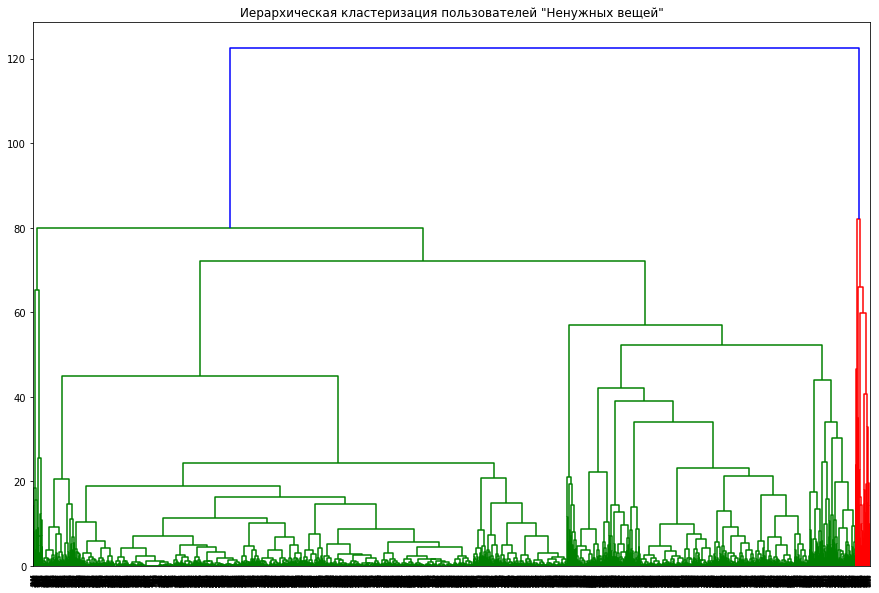

In [46]:
# Нарисуем дендограмму
linked = linkage(cluster_table_st, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация пользователей "Ненужных вещей"')
plt.show()

<div class="alert alert-block alert-info">
Нам предлагают поделить пользователей всего на два кластера, один огромный и один маленький. Я все-таки остановлюсь на выборе трех кластеров, есть риск, что при выборе всего двух кластеров мы упустим отличающиеся особенности.
</div>


In [47]:
# Обучим модель алгоритмом K-means
km = KMeans(n_clusters = 3, random_state=0)
labels = km.fit_predict(cluster_table_st)

# Добавим метки кластера в датасет
cluster_table['cluster'] = labels

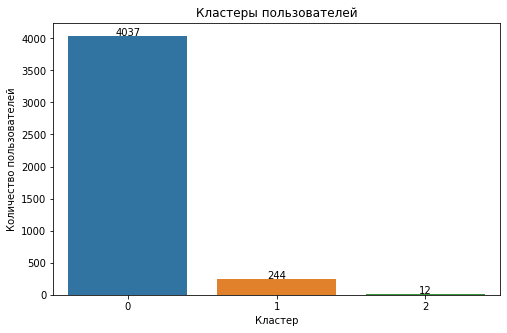

In [48]:
# Построим распределение
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x='cluster', data = cluster_table, order = cluster_table['cluster'].value_counts().index)
plt.title('Кластеры пользователей')
plt.xlabel('Кластер')
plt.ylabel('Количество пользователей')


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
    height + 10,
    '{}'.format(height),
    ha="center")
plt.show()

<div class="alert alert-block alert-info">
Мы получили огромный первый кластер, куда входят почти все пользователи, небольшой нулевой кластер и совсем крошечный кластер под номером 2. Посмотрим как у нас распределились ключевые метрики по кластерам.
</div>

In [49]:
metrics = cluster_table[['user.id', 'mean_session', 'count_session', 'count_event', 'cluster']]
metrics.groupby('cluster').median().T

cluster,0,1,2
mean_session,8.0,16.0,13.5
count_session,1.0,7.5,38.5
count_event,8.0,76.0,359.0


<div class="alert alert-block alert-info">
По всем ключевым метрикам наблюдается большое различие между пользователями кластеров. Посмотрим на распределение данных, лучше всего это отразят боксплоты.
</div>

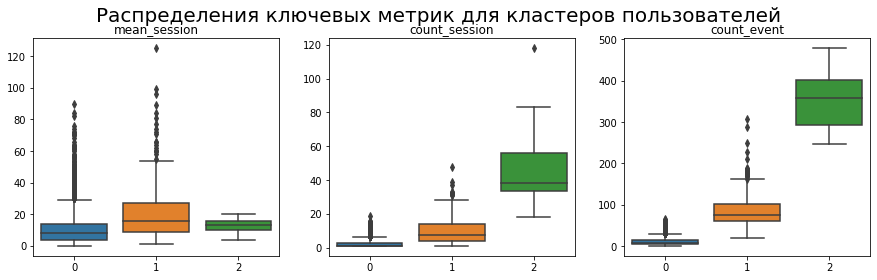

In [50]:
# Столбцы для боксплотов
columns = ['mean_session', 'count_session', 'count_event']

# Построим боксплоты
fig, ax = plt.subplots(1,3, figsize=(15,4))
fig.suptitle('Распределения ключевых метрик для кластеров пользователей', y = .99, fontsize=20)

number = 0
for i in columns:
    sns.boxplot(x='cluster', y=i, ax=ax[number], data=cluster_table)
    ax[number].set_xlabel('')
    ax[number].set_ylabel('')
    ax[number].set_title(i)
    number += 1
plt.show()

<div class="alert alert-block alert-info">
Теперь посмотрим, как распределились действия
</div>

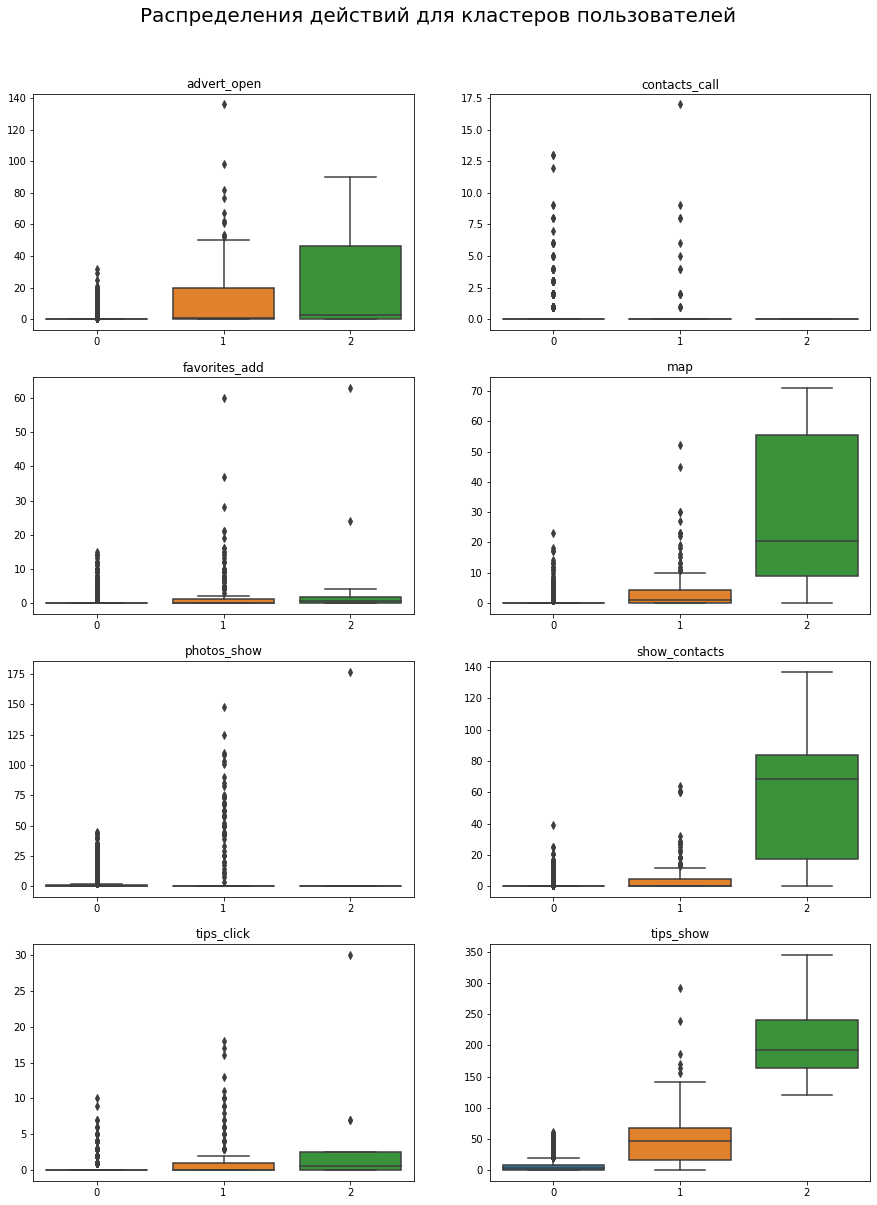

In [51]:
# Столбцы для боксплотов
columns = ['advert_open', 'contacts_call', 'favorites_add', 'map', 'photos_show', 'show_contacts', 'tips_click', 'tips_show']

# Построим боксплоты
fig, ax = plt.subplots(4,2, figsize=(15,20))
fig.suptitle('Распределения действий для кластеров пользователей', y = .94, fontsize=20)
ax = ax.ravel()
number = 0
for i in columns:
    sns.boxplot(x='cluster', y=i, ax=ax[number], data=cluster_table)
    ax[number].set_xlabel('')
    ax[number].set_ylabel('')
    ax[number].set_title(i)
    number += 1
plt.show()

## Итоги кластеризации

Мы получили три кластера, пользователи которых значительно различаются по ключевым метрикам.

В кластер под номером 1 попало большинство пользователей, по всей видимости это среднестатистические пользователи приложения, не проявляющие особой активности, редко возвращающиеся в него и проводяшие в нем немного времени.

В кластер под номером 0 попадает целевая аудитория приложени. Это любители "ненужных вещей", проводящие в приложении много времени, часто возвращающиеся в него и совершающие в нем много действий.

В кластер под номером 2 попали наиболее активные пользователи. У них гораздо большее количество сессий и действий в приложении, среднее значение этих показателей превышает значения пользователей нулевого кластера в шесть раз.При этом среднее время сессии немного ниже, чем у пользователей нулевого кластера.

Если посмотреть на распределение действий по кластерам, то вполне ожидаемо видно, что пользователи первого кластера совершали гораздо меньше каждое из действий, чем пользователи двух других кластеров.

Смотрится подозрительно, что пользователи второго кластера открывали больше всех объявлений, смотрели карту, в разы больше других смотрели контакты, но при этом не открывали фотки и не звонили по объявлениям. И если звонки можно объяснить тем, что 15 пользователей могли и не звонить, а просто серфили по сайту и искали что-то интересное для себя, то почему они при этом не открывали фотки объяснить уже трудно. Я могу предположить, что это могло быть связано с техническими проблемами на их устройствах и фотки просто не открывались, но ведь эти пользователи часто возвращались в приложение, продолжали совершать наибольшее число действий. На пользователей этого кластера следует обратить внимание, возможно в нем присутствуют мошенники, собирающие телефонную базу.

Пользователи нулевого кластера сбалансированно распределены по всем показателям

## Проверка гипотез

1. Проверка гипотезы о том, что пользователи, установившие приложения по ссылка из Яндекса и Гугла демонстрируют различную конверсию в просмотры контактов;
2. Проверка гипотезы о том, что пользователи, которые пользовались картой размещенных объявлений демонстрируют большую конверсию в просмотры контактов, чем пользователи, которые не пользовались картой, но при этом открывали карточки с объявлениями.
    
    - Выдвинутая гипотеза - пользователи, пользующиеся картой, демонстрируют большую конверсию в просмотр контактов
    - Альтернативная гипотеза - пользователи, пользующиеся картой, демонстрируют меньшую конверсию в просмотр контактов
    - Нулевая гипотеза - различий нет

<div class="alert alert-block alert-info">
Проверим, что в таблице с источниками нет лишних источников, а затем соединим ее с таблицей кластеризации, оставив только необходимые нам столбцы. Затем разделим таблицы по источникам установки и проведем статистический тест для проверки нулевой гипотезы о том, что между просмотрами контактов нет разницы.
</div>


In [52]:
source_data['source'].value_counts()

yandex    1934
other     1230
google    1129
Name: source, dtype: int64

In [53]:
source_hypothesis = pd.merge(source_data, cluster_table[['user.id', 'show_contacts']], on = 'user.id')\
                                                    .query('source == "yandex" or source == "google"')
source_hypothesis.head()

,user.id,source,show_contacts
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,0.0
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2.0
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google,0.0
5,17f6b2db-2964-4d11-89d8-7e38d2cb4750,yandex,2.0
6,62aa104f-592d-4ccb-8226-2ba0e719ded5,yandex,0.0


In [54]:
# Подготовим данные к z-тесту
yandex_1 = source_hypothesis.query('source == "yandex" and show_contacts != 0')
yandex = source_hypothesis.query('source == "yandex"')
google_1 = source_hypothesis.query('source == "google" and show_contacts != 0')
google = source_hypothesis.query('source == "google"')

In [55]:
alpha = .05

p1 = len(yandex_1)/len(yandex)
    
p2 = len(google_1)/len(google)

p_combined = (len(yandex_1) + len(google_1)) / (len(yandex) + len(google))

difference = p1 - p2

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/len(yandex) + 1/len(google)))

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

p-значение:  0.93215849399865
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div class="alert alert-block alert-info">
Проверим гипотезу об использовании карты объявлений
</div>

In [56]:
# Пользователи, пользовавшиеся картой
map_users = cluster_table.query('map != 0')
# Пользователи, не пользовавшиеся картой, но открывающие объявления
no_map_users = cluster_table.query('map == 0 and (advert_open != 0 or tips_click != 0)')

In [57]:
map_users_1 = map_users.query('show_contacts != 0')
no_map_users_1 = no_map_users.query('show_contacts != 0')

<div class="alert alert-block alert-info">
Мы проводим односторонний тест, а значит p.value нужно поделить пополам.
</div>

In [58]:
alpha = .05

p1 = len(map_users_1)/len(map_users)
    
p2 = len(no_map_users_1)/len(no_map_users)

p_combined = (len(map_users_1) + len(no_map_users_1)) / (len(map_users) + len(no_map_users))

difference = p1 - p2

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/len(map_users) + 1/len(no_map_users)))

distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value/2)
if (p_value/2 < alpha) and p1 >  p2:
    print("Принимаем выдвинутую гипотезу")
elif (p_value/2 < alpha) and p1 <  p2:
    print("Принимаем альтернативную гипотезу")
else:
    print("Принимаем нулевую гипотезу")

p-значение:  0.12334999412912118
Принимаем нулевую гипотезу


<div class="alert alert-block alert-info">
У нас есть основания предполагать, что пользователи неиспользовавшие карту демонстрируют большую конверсию в просмотры контактов, чем пользователи, использующие карту
</div>

## Итоги проверки гипотез

1. Нет основания считать, что пользователи, установшие приложения по ссылке из яндекса демонстрируют различную конверсию с пользователями, установившими приложение из гугла.
2. Есть основания предполагать, что пользователи неиспользовавшие карту демонстрируют большую конверсию в просмотры контактов, чем пользователи, использующие карту

# Общий вывод

В ходе предобработки данные проверены, даты приведены к нужному типу и переименован столбец идентификатора пользователя в таблице с источниками установки приложения.

В ходе исследовательского анализа получены следующие данные:

1. Количество пользователей в логе - 4293
2. Мы располашаем данными за 28 дней, с 7-го октября по 3 ноября 2019 года
3. Данные о событиях полные за весь рассматриваемый промежуток времени
4. Лог разбит на сессии
5. Выделены группы пользователей в зависимости от количества сессий:
    - 1 сессия - 47.7%
    - 2-5 сессий - 43.4%
    - 6-10 сессий - 8%
    - 11-20 сессий - 0.7%
    - более 20 сессий - 0.1%
6. Выделены группы пользователей в зависимости от среднего времени сессий:
    - 0 минут - 2%
    - 1 - 5 минут - 28%
    - 6 - 20 минут - 46.4%
    - 21 - 40 минут - 17%
    - более 40 минут - 6.5%
7. Выделены группы пользователей в зависимости от количества совершаемых действий:
    - одно действие - 1.5 %
    - от 2 до 10 действий - 55.1%
    - от 11 до 30 действий - 31.2%
    - от 31 до 60 действий - 7.4%
    - более 60 действий - 4.8%
8. Выделены группы пользователей на основе выполнения целевого действия - просмотра контакта:
    - не доходили до просмотра контактов - 77.1%
    - просматривали контакты - 22.3%
    - подозрительная активность, просмотр более 25 контактов 0.5%
9. Построена общая таблица с группами пользователей.
10. Выдвинута гипотеза, что пользователи, которые пользовались картой размещенных объявлений демонстрируют большую конверсию в просмотры контактов, чем пользователи, которые не пользовались картой, но при этом открывали карточки с объявлениями.



В ходе кластеризации пользователи поделены на три кластера, на основании выполняемых ими действий в приложении и ключевым метрикам. Выделены основные черты различия кластеров между собой.

В кластер под номером 1 попало большинство пользователей, по всей видимости это среднестатистические пользователи приложения, не проявляющие особой активности, редко возвращающиеся в него и проводяшие в нем немного времени.

В кластер под номером 0 попадает целевая аудитория приложени. Это любители "ненужных вещей", проводящие в приложении много времени, часто возвращающиеся в него и совершающие в нем много действий.

В кластер под номером 2 попали наиболее активные пользователи. У них гораздо большее количество сессий и действий в приложении, среднее значение этих показателей превышает значения пользователей нулевого кластера в шесть раз.При этом среднее время сессии немного ниже, чем у пользователей нулевого кластера.

Если посмотреть на распределение действий по кластерам, то вполне ожидаемо видно, что пользователи первого кластера совершали гораздо меньше каждое из действий, чем пользователи двух других кластеров.

Смотрится подозрительно, что пользователи второго кластера открывали больше всех объявлений, смотрели карту, в разы больше других смотрели контакты, но при этом не открывали фотки и не звонили по объявлениям. И если звонки можно объяснить тем, что 15 пользователей могли и не звонить, а просто серфили по сайту и искали что-то интересное для себя, то почему они при этом не открывали фотки объяснить уже трудно. Я могу предположить, что это могло быть связано с техническими проблемами на их устройствах и фотки просто не открывались, но ведь эти пользователи часто возвращались в приложение, продолжали совершать наибольшее число действий. На пользователей этого кластера следует обратить внимание, возможно в нем присутствуют мошенники, собирающие телефонную базу.

Пользователи нулевого кластера сбалансированно распределены по всем показателям

Пользователи третьего класса активно смотрели фотографии и, практические единственные, совершали звонки по объявлениям. При этом они практически не открывали карточки с объявлениями, не пользовались картой и не видели рекомендаций. Скорее всего эти пользователи попадали в объявления, например, напрямую по ссылке из поисковика.

В ходе проверки гипотез пришли к выводу, что нет основания считать различной конверсию в просмотры контактов между пользователями, установившими приложения из гугла или яндекса.

Но есть основания предполагать, что пользователи неиспользовавшие карту демонстрируют большую конверсию в просмотры контактов, чем пользователи, использующие карту

# Презентация

https://cloud.mail.ru/public/2WkY/3jF8M3AMu